In [1]:
import qutip as qt 
from qutip.core import CFExponent
from qutip import destroy, qeye,tensor,basis,mesolve
from scipy.integrate import quad
import matplotlib.pyplot as plt
from qutip.core.environment import BosonicEnvironment
from qutip.solver.heom import BosonicBath
import numpy as np

Now on to the simulation, first the pseudomode bit

In [2]:
def _matsubara_zero_integrand(t, coup_strength, bath_broad, bath_freq):
    """
    Integral for the zero temperature Matsubara exponentials.
    """
    lam = coup_strength
    gamma = bath_broad
    w0 = bath_freq

    omega = np.sqrt(w0 ** 2 - (gamma / 2) ** 2)
    a = omega + 1j * gamma / 2.0
    aa = np.conjugate(a)

    prefactor = -(lam ** 2 * gamma) / np.pi
    integrand = lambda x: prefactor * ((x * np.exp(-x * t)) / ((a ** 2 + x ** 2) * (aa ** 2 + x ** 2)))
    return quad(integrand, 0, np.inf,limit=5000,complex_func=True)[0]
def C0(t,coupling,gamma,w0,beta=np.inf):
    Gamma= gamma/2
    Omega= np.sqrt(w0**2 -Gamma**2)
    if beta!=np.inf:
        tempc0r= (1/np.tanh(beta*(Omega+ Gamma*1j)/2))*np.exp(1j*Omega*t)
    else:
        tempc0r= np.exp(1j*Omega*t)
    c0r=tempc0r+np.conjugate(tempc0r)
    c0i= -2j*np.sin(Omega*t)
    return (c0r+c0i)*(coupling**2)/(4*Omega)*np.exp(-Gamma*t)

In [3]:
t=np.linspace(0,120,1000)
lam=0.1
gamma=1
w0=1
vectorized=np.vectorize(lambda i:_matsubara_zero_integrand(i,lam,gamma,w0),otypes=[complex])
C=vectorized(t)
c2=np.array([_matsubara_zero_integrand(i,lam,gamma,w0) for i in t])

In [4]:
def corr(t):
    return np.exp(-t)

In [5]:
bb5 = BosonicEnvironment.from_correlation_function(vectorized, t, T=0,tMax=50)

In [6]:
bbfit,finfo =bb5.approx_by_cf_fit(t,Ni_max=1,Nr_max=1,target_rsme=None)

In [7]:
print(finfo["summary"])

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 1 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         |-1.70e-03 |-7.42e-01 |1.44e-15                           | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                            
                                                                     |                                                                      
A normalized RMSE of  2.80e-04 was obtained for the the real part of |A normalized RMSE of  0.00e+00 was obtained for the the i

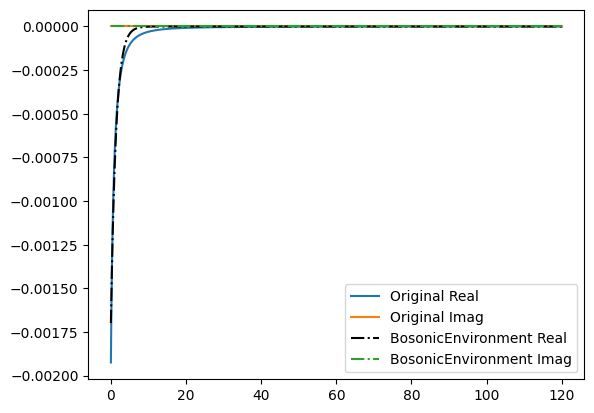

In [8]:
plt.plot(t, np.real(C), label='Original Real')
plt.plot(t, np.imag(C), label='Original Imag')
plt.plot(t, np.real(bbfit.correlation_function(t)),"k-.", label='BosonicEnvironment Real')
plt.plot(t, np.imag(bbfit.correlation_function(t)),"-.", label='BosonicEnvironment Imag')
plt.legend()
plt.show()

continue according to https://arxiv.org/pdf/1903.05892

In [9]:
bath=qt.core.UnderDampedEnvironment(T=0,lam=lam,gamma=gamma,w0=w0) 

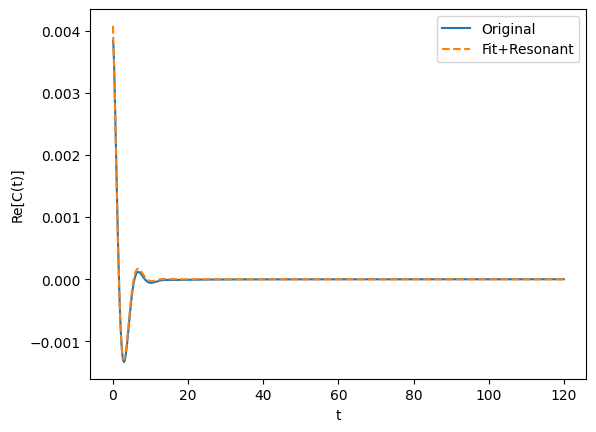

In [ ]:
plt.plot(t,np.real(bath.correlation_function(t)),label="Original")
plt.plot(t,np.real(C0(t,lam,gamma,w0)+bbfit.correlation_function(t)),'--',label="Fit+Resonant")
plt.ylabel("Re[C(t)]")
plt.xlabel("t")
plt.legend()
plt.show()

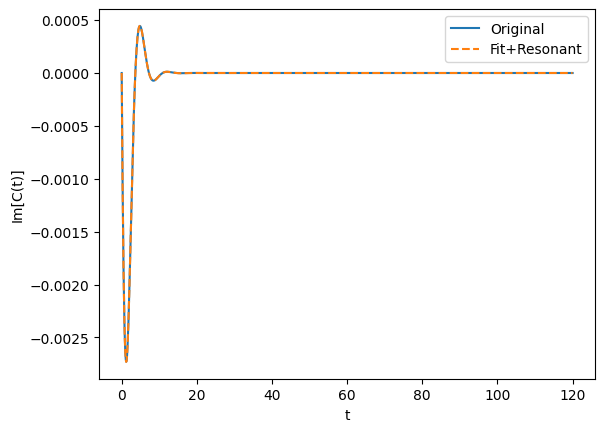

In [11]:
plt.plot(t,np.imag(bath.correlation_function(t)),label="Original")
plt.plot(t,np.imag(C0(t,lam,gamma,w0)+bbfit.correlation_function(t)),'--',label="Fit+Resonant")
plt.ylabel("Im[C(t)]")
plt.xlabel("t")
plt.legend()
plt.show()

# Now I just need to construct my pseudomodes according to 

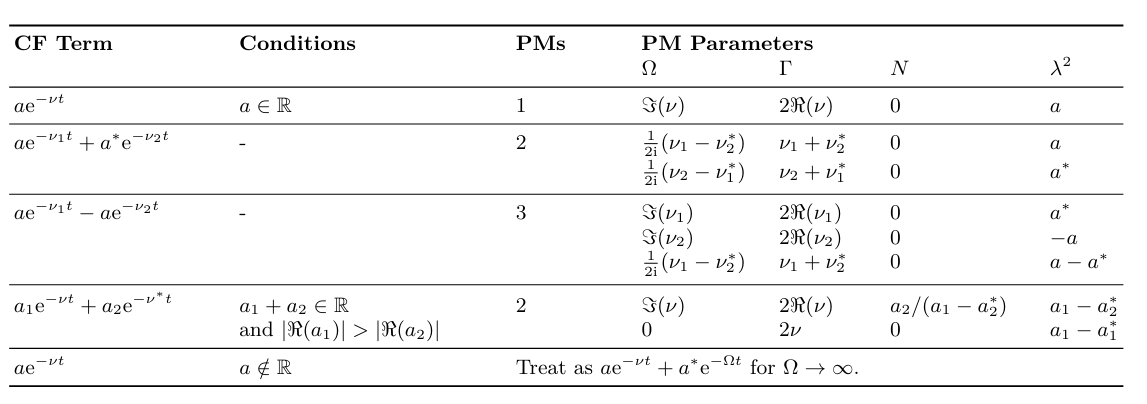

In [12]:
# from IPython.display import display, Markdown
# display(Markdown("### In my case I have three exponentials: \n "
#                  "\n - The Resonant mode \n $a=\\frac{\\lambda^{2}}{2 \\Omega}$ and $\\nu=(\\Gamma+i\\Omega)t$ "
#                  "\n ### And the two exponents obtained from the Bi-exponential fit of the"
#                  "Matsubara contribution: \n"
#                  "\n - Matsubara "rf"$a_{1}$={finfo['params_real'][0][0]:2e} and" rf" $\nu_{1}$={finfo['params_real'][0][1]+1j*finfo['params_real'][0][2]:2e}"
#         "\n - Matsubara "rf"$a_{2}$={finfo['params_real'][1][0]:2e} and" rf" $\nu_{2}$={finfo['params_real'][1][1]+1j*finfo['params_real'][1][2]:2e}") )

Since I always use the constans $a_{k}$ being real numbers, there is one pseudomode per exponent.
Notice in this case the exponents are basically real as the imaginary part is basically rounding off error. This indicates that the energy of the pseudomodes is basically zero at zero temperature, a feat that I saw across multiple parameters (except for the resonant mode)

Since the fitted bath (using this integral) does not contain the resonant mode then I need to add the exponents of the resonant mode to the ExponentialBath  (Probably not the most pythonic way to do it)

In [13]:
Gamma=gamma/2
Omega=np.sqrt(w0**2 - Gamma**2)
ck=(lam**2)/(2*Omega)
vk=(-Gamma+1j*Omega)
C0_contrib=[CFExponent(type="R",ck=ck,vk=-np.conjugate(vk))]
bbfit.exponents.extend(C0_contrib)

Now I just simulate with mesolve, For That I use a custom class that implements the Pseudomode equation for me

In [14]:
class pseudomode:
    def __init__(self,Hsys,Q,bath):

        self.Hsys=Hsys
        self.Q=Q
        self.bath=bath
        self.coefficients()
    def coefficients(self):
        cks=np.zeros(len(self.bath.exponents),dtype=np.complex128)
        vks=np.zeros(len(self.bath.exponents),dtype=np.complex128)
        seen=set()
        i=0
        for exp in self.bath.exponents:
            if exp.vk not in seen:
                if exp.type ==CFExponent.types["R"]:
                    cks[i]=exp.ck 
                else:
                    cks[i]=-1j*exp.ck
                vks[i]=-exp.vk

                seen.add(exp.vk.conjugate())
                i=i+1
            
        self.cks=cks[cks!=0]
        self.vks=vks[vks!=0]
    def tensor_id(self,pos,cutoff=2,op=None):
        temp=[qeye(cutoff)]*(len(self.cks)+1)
        if pos!=0:
            temp[0]=qeye(self.Hsys.shape[0])
            temp[pos]=destroy(cutoff)
        else:
            temp[0]=op
        return tensor(temp)
    def hamiltonian(self,cutoff=2):
        Hsys=self.tensor_id(0,cutoff,self.Hsys)
        Q=self.tensor_id(0,cutoff,self.Q)
        destroys=[self.tensor_id(i+1,cutoff) for i in range(len(self.cks))]
        for i in destroys:
            i.dims=Hsys.dims
        Hpm=sum([np.imag(i)*destroys[k].dag()*destroys[k] for k,i in enumerate(self.vks) ])
        Hsys_pm=sum([np.sqrt(i+0j)*(destroys[k].dag()+destroys[k])*Q for k,i in enumerate(self.cks) ])
        Heff=Hsys_pm+Hpm+Hsys
        return Heff,destroys

    def prepare(self,cutoff,initial):
        init=[initial]+[basis(cutoff,0)]*(len(self.cks))
        psi02 = tensor(init)
        psi02=psi02*psi02.dag()
        return psi02.to("CSR")
    
    def evolution(self,initial,cutoff,t,e_ops=[],options={"normalize_output":False}):
        Heff,d=self.hamiltonian(cutoff)
        initial=self.prepare(cutoff,initial)
        e_ops=[self.tensor_id(0,cutoff,i) for i in e_ops]
        c_ops =[np.sqrt(-2*np.real(i) +0j)*d[k] for k,i in enumerate(self.vks) ]
        return mesolve(Heff, initial, t, c_ops=c_ops, e_ops=e_ops,options=options)


In [15]:
example=pseudomode(Hsys=qt.sigmax()/2, Q=qt.sigmaz(),bath=bbfit)

In [16]:
initial_ket=(1/np.sqrt(2))*(qt.basis(2,0)+ 1j*qt.basis(2,1))

In [ ]:
initial_ket*initial_ket.dag()

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5+0.j  0. -0.5j]
 [0. +0.5j 0.5+0.j ]]

In [18]:
ans=example.evolution(initial_ket,4,t,e_ops=[qt.sigmaz()])
result_fit_integral = (ans.expect[0] + 1)/2

After Simulating the Pseudomodes, I create an Enviroment for HEOM, using a simple correlation fit instead of the Fit + Resonant

In [19]:
tlist = np.linspace(0, 250, 1000)
heomenv,finfo=bath.approx_by_cf_fit(tlist,Nr_max=2,Ni_max=1)
print(finfo['summary'])

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 2 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         | 7.66e-03 |-5.60e-01 |8.27e-01                           | 1         |-5.77e-03 |-5.00e-01 |8.66e-01                            
 2         |-3.82e-03 |-9.95e-01 |4.13e-11                           |                                                                      
                                                                     |A normalized RMSE of  1.14e-06 was obtained for the the i

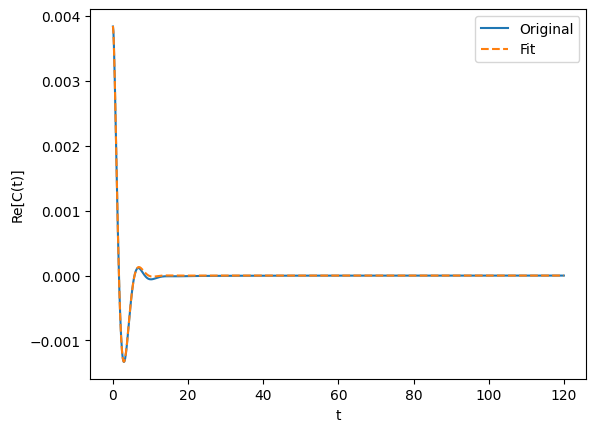

In [20]:
plt.plot(t,np.real(bath.correlation_function(t)),label="Original")
plt.plot(t,np.real(heomenv.correlation_function(t)),'--',label="Fit")
plt.ylabel("Re[C(t)]")
plt.xlabel("t")
plt.legend()
plt.show()

I create a heom bath from the environments

In [21]:
heombath=BosonicBath.from_environment(heomenv,qt.sigmax())

I also simulate pseudomodes with this different bath

In [22]:
example2=pseudomode(Hsys=qt.sigmaz()/2, Q=qt.sigmax(),bath=heomenv)
ans=example2.evolution(initial_ket,4,t,e_ops=[qt.sigmap()])
result_fit_correlation = ans.expect[0] 

Solving for HEOM

In [23]:
solver = qt.heom.HEOMSolver(qt.sigmaz()/2,
                    [heombath], max_depth=7)
result = solver.run(initial_ket*initial_ket.dag(), t)

10.0%. Run time:   0.04s. Est. time left: 00:00:00:00
20.0%. Run time:   0.09s. Est. time left: 00:00:00:00
30.0%. Run time:   0.14s. Est. time left: 00:00:00:00
40.0%. Run time:   0.19s. Est. time left: 00:00:00:00
50.1%. Run time:   0.25s. Est. time left: 00:00:00:00
60.1%. Run time:   0.30s. Est. time left: 00:00:00:00
70.1%. Run time:   0.35s. Est. time left: 00:00:00:00
80.1%. Run time:   0.40s. Est. time left: 00:00:00:00
90.1%. Run time:   0.45s. Est. time left: 00:00:00:00
100.0%. Run time:   0.51s. Est. time left: 00:00:00:00
Total run time:   0.51s


In [24]:
heom_result=[i[0,0] for i in result.states]

In [25]:
from nmm import csolve,redfield
cum2=csolve(Hsys=qt.sigmaz()/2,t=t,baths=[heombath],Qs=[ qt.sigmax()],eps=1e-4,cython=False,matsubara=True)
heombath.T=0
#cum2=redfield.redfield(Hsys=qt.sigmaz()/2,t=tlist,baths=[heombath],Qs=[qt.sigmax()],eps=1e-4,matsubara=False)


In [26]:
def rotation(data, t, Hsys):
    rotated = [
        (-1j * Hsys * t[i]).expm()
        * qt.Qobj(data[i],dims=Hsys.dims)
        * (1j * Hsys * t[i]).expm()
        for i in range(len(t))
    ]
    return rotated

In [27]:
result_cum2=cum2.evolution(initial_ket*initial_ket.dag())
result_cum2=rotation(result_cum2,tlist,cum2.Hsys)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Computing Exponential of Generators . . . .: 100%|██████████| 1000/1000 [00:00<00:00, 5218.36it/s]


In [28]:
cum_result=[i[0,0] for i in result_cum2]

In [ ]:
len(t)

1000

/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


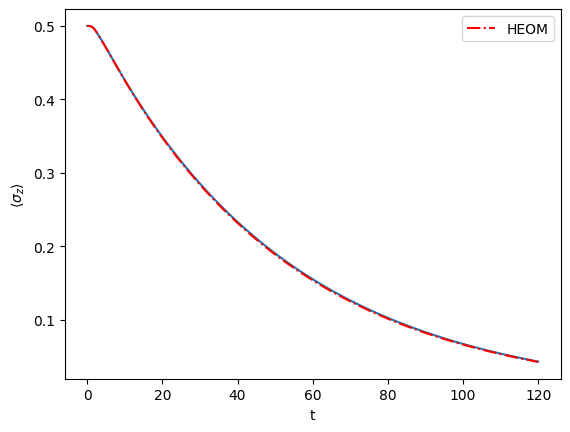

In [30]:
plt.plot(t, cum_result)#, marker='x',linestyle="None",markevery=10,label="Cumulant")
#plt.plot(t, result_fit_integral, color="k",label="Pseudomode Integral Fit")
plt.plot(t, heom_result,"-.", color="r",label="HEOM")

plt.ylabel(r"$\langle \sigma_{z}\rangle$")
plt.xlabel("t")
plt.legend()
plt.show()# Add

In [31]:
assert 1==0

AssertionError: 

Cross-Checking with the reaction Coordinate mapping

In [31]:
levels=10
Hq=qt.sigmax()/2
Q=qt.sigmaz()
aq=qt.destroy(levels)
aqd=qt.create(levels)
aqrc=qt.tensor(qt.qeye(2),aq)
aqdrc=qt.tensor(qt.qeye(2),aqd)
qHRC = qt.tensor(Hq, qt.qeye(levels)) +np.sqrt(1/(2*w0))*(lam)*qt.tensor(Q, qt.qeye(levels))*(aqrc+aqdrc)+w0*aqdrc*aqrc

In [32]:
eop=qt.tensor(qt.sigmaz(),qt.qeye(levels))
psi0 = qt.tensor(initial_ket, qt.basis(levels,0))
Qrc= (aqrc + aqrc.dag())/np.sqrt(2*w0)
resultrc=qt.mesolve(H=qHRC,c_ops=[np.sqrt(gamma)*aqrc],e_ops=[eop],rho0=psi0,tlist=t,options={"normalize_output":False})
rc_result=(1+resultrc.expect[0])/2

In [33]:
import numpy as np

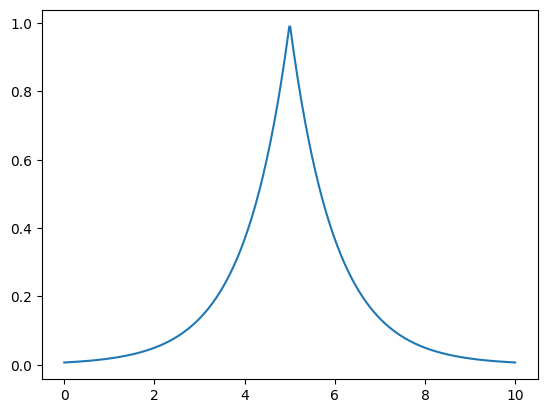

In [34]:
t=np.linspace(0,10,500)
#w=np.linspace(-0.30,0.30,100)
c0=np.exp((-np.abs(t-5)))
c0_transform=np.exp((-5+2j)*t)*(np.exp(10*t)*np.heaviside(-t,0)+np.heaviside(t,0))#np.sqrt(2/np.pi)*np.exp(5j*w)/(1+w**2)
wc=t[np.argmax(c0)]
# plt.plot(t,c0)
# plt.axvline(wc,color='r')
# plt.show()
plt.plot(t,c0)
plt.show()

In [35]:
bb5 = BosonicEnvironment.from_correlation_function(c0, t, T=0,tMax=50)

In [36]:
heomenv,finfo=bb5.approx_by_cf_fit(t,Nr_max=2,Ni_max=1)
print(finfo['summary'])

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 2 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         | 1.19e-01 | 1.00e-01 |1.56e-01                           | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                            
 2         | 1.04e-01 | 1.00e-01 |1.56e-01                           |                                                                      
                                                                     |A normalized RMSE of  0.00e+00 was obtained for the the i

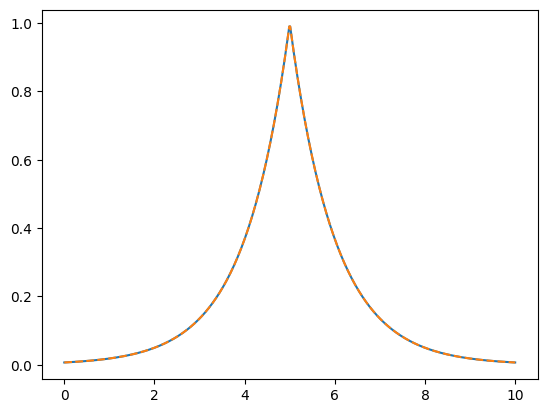

In [37]:
plt.plot(t,c0)
plt.plot(t,bb5.correlation_function(t),"--")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (500,) and (1000,)

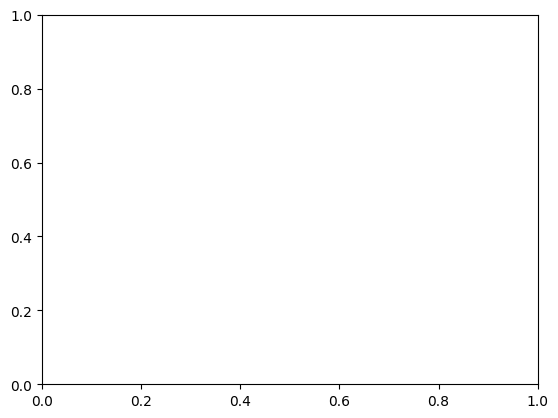

In [38]:
plt.plot(t, result_fit_correlation, color="k",label='Pseudomodes')
plt.plot(t, heom_result,"-.", color="r",label="HEOM")
plt.plot(t, rc_result,marker='x', linestyle='None',markevery=10,color="b",label="Reaction Coordinate")
plt.ylabel(r"$\langle \sigma_{z}\rangle$")
plt.xlabel("t")
plt.legend()
plt.show()# Add